In [1]:
# !pip install torchinfo

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Checking if a GPU is available for training a model
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 969219004987927342
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6110272819374213853
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18080838343037523544
 physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
 xla_global_id: 2144165316]

In [4]:
# Display detailed information about the system's memory
# !cat /proc/meminfo

In [5]:
# Display detailed information about the system's central processing unit (CPU)
# !cat /proc/cpuinfo

In [6]:
# !pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
# !mkdir /root/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:
#     f.write('{"username":"khushalidaga08","key":"c7aaa2a8acee7e33b56fe4195f198b4d"}')
#     # Put your kaggle username & key here

# !chmod 600 /root/.kaggle/kaggle.json

<h1> Part 1: Data Acquisition and Preprocessing <h1>

In [7]:
!kaggle datasets download behrad3d/nasa-cmaps
! mkdir train
! unzip nasa-cmaps.zip -d train

Dataset URL: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps
License(s): CC0-1.0
  0%|                                               | 0.00/12.3M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 12.3M/12.3M [00:00<00:00, 137MB/s]
Archive:  nasa-cmaps.zip
  inflating: train/CMaps/Damage Propagation Modeling.pdf  
  inflating: train/CMaps/RUL_FD001.txt  
  inflating: train/CMaps/RUL_FD002.txt  
  inflating: train/CMaps/RUL_FD003.txt  
  inflating: train/CMaps/RUL_FD004.txt  
  inflating: train/CMaps/readme.txt  
  inflating: train/CMaps/test_FD001.txt  
  inflating: train/CMaps/test_FD002.txt  
  inflating: train/CMaps/test_FD003.txt  
  inflating: train/CMaps/test_FD004.txt  
  inflating: train/CMaps/train_FD001.txt  
  inflating: train/CMaps/train_FD002.txt  
  inflating: train/CMaps/train_FD003.txt  
  inflating: train/CMaps/train_FD004.txt  
  inflating: train/CMaps/x.txt       


In [8]:
PM_train = '/kaggle/working/train/CMaps/train_FD001.txt'
PM_test = '/kaggle/working/train/CMaps/test_FD001.txt'
PM_truth = '/kaggle/working/train/CMaps/RUL_FD001.txt'

# Binary classification
Predict if an asset will fail within certain time frame (e.g. cycles)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, GRU
from torchinfo import summary
import keras

# define path to save model
model_path = 'binary_model.keras'

## Data Ingestion

In [10]:
# Read training data - Aircraft engine run-to-failure data
train_df = pd.read_csv(PM_train, sep=' ', header=None) # Read the txt file, use appropriate separator and header
train_df.drop([26, 27], axis=1, inplace=True)  # Explore the data on your own and remove unnecessary columns
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]   # Assign names to all the columns

train_df = train_df.sort_values(['id', 'cycle'])  # Sort by id and cycle

# # Read test data - Aircraft engine operating data without failure events recorded
test_df = pd.read_csv(PM_test, sep=' ', header=None)  # Read the txt file, use appropriate separator and header
test_df.drop([26, 27], axis=1, inplace=True)  # Explore the data on your own and remove unnecessary columns
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)] # Assign names to all the columns

# # Read ground truth data - True remaining cycles for each engine in testing data
truth_df = pd.read_csv(PM_truth, sep=' ', header=None) # Read the txt file, use appropriate separator and header
truth_df.drop(1, axis=1, inplace=True)  # Explore the data on your own and remove unnecessary columns

## Data Preprocessing

In [11]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL (Remaining Useful Life or Time to Failure)

# TODO: Calculate the maximum cycle value for each engine (id) and store it in a new DataFrame (rul)
rul = train_df.groupby('id')['cycle'].max().reset_index()
# TODO: Rename the columns in the rul DataFrame
rul.columns = ['id', 'max_cycle']
# TODO: Merge the rul DataFrame with the original train_df based on the 'id' column
train_df = train_df.merge(rul, on='id', how='left')
# TODO: Calculate the Remaining Useful Life (RUL) by subtracting the current cycle from the maximum cycle
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
# TODO: Remove the temporary column used to calculate RUL
train_df.drop('max_cycle', axis=1, inplace=True)

# Generate label columns for training data
# We will only make use of "label1" for binary classification,
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15

# TODO: Create a binary label ('label1') indicating if the engine will fail within w1 cycles (1) or not (0)
train_df['label1'] = train_df['RUL'].apply(lambda x: 1 if x <= w1 else 0)  # Replace with the correct threshold value and label values
# TODO: Initialize a second label ('label2') as a copy of 'label1'
train_df['label2'] = train_df['label1'].copy()
# TODO: Update 'label2' to indicate if the engine will fail within w0 cycles (2) or not (0/1)
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2 # Replace with the correct threshold value and label value


# MinMax normalization (from 0 to 1)
# TODO: Create a normalized version of the 'cycle' column (e.g., 'cycle_norm') using the original 'cycle' values
train_df['cycle_norm'] = train_df['cycle'] / train_df.groupby('id')['cycle'].transform('max')  # Replace with the correct normalization code
# TODO: Select the columns to be normalized (all columns except 'id', 'cycle', 'RUL', 'label1', and 'label2')
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])  # Replace with the correct column selection code
# TODO: Initialize a MinMaxScaler object to scale values between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()  # Replace with the correct scaler initialization code
# TODO: Apply MinMaxScaler to the selected columns and create a new normalized DataFrame
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), columns=cols_normalize)  # Replace with the correct normalization code
# TODO: Join the normalized DataFrame with the original DataFrame (excluding normalized columns)
join_df = train_df[['id', 'cycle', 'RUL', 'label1', 'label2']].join(norm_train_df)  # Replace with the correct join code
# TODO: Reorder the columns in the joined DataFrame to match the original order
train_df = join_df.reindex(columns=train_df.columns)  # Replace with the correct reindexing code

######
# TEST
######
# MinMax normalization (from 0 to 1)
# TODO: Similar to the MinMax normalization done for Train, complete the code below.
test_df['cycle_norm'] = test_df['cycle'] / test_df.groupby('id')['cycle'].transform('max')
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), columns=cols_normalize)
test_join_df = test_df[['id', 'cycle']].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
# test_df = NotImplemented

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
# TODO: Calculate the maximum cycle value for each engine (id) in the test data and store it in a new DataFrame (rul)
rul = test_df.groupby('id')['cycle'].max().reset_index()
# TODO: Rename the columns in the rul DataFrame
rul.columns = ['id', 'max']
# TODO: Merge the rul DataFrame with the original test_df based on the 'id' column
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
# TODO: Remove the temporary column used to calculate RUL
truth_df.drop(['more'], axis=1, inplace=True)

# TODO: Merge the adjusted truth_df with the test_df to generate RUL values for test data
test_df = test_df.merge(truth_df[['id', 'max']], on='id', how='left')
# TODO: Calculate the Remaining Useful Life (RUL) by subtracting the current cycle from the maximum cycle
test_df['RUL'] = test_df['max'] - test_df['cycle']
# TODO: Remove the temporary column used to calculate RUL
test_df.drop('max', axis=1, inplace=True)

# Generate binary label columns (label1 and label2) based on RUL values and thresholds w0 and w1
# TODO: Similar to what you did in the train dataframe
test_df['label1'] = test_df['RUL'].apply(lambda x: 1 if x <= w1 else 0)
test_df['label2'] = test_df['label1'].copy()
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

<h2>Feature Engineering</h2>

In [12]:
# 1. Feature Engineering: Calculate Moving Averages
# We calculate the moving averages for sensor measurements using a 3-cycle (time step) window.
# The window size of 3 is used to smooth short-term fluctuations, providing more stable trend values.
# This approach helps capture trends in the data while reducing noise.
window_size = 3

for col in train_df:
    # Calculate moving average for each unit in the training data
    train_df[f'{col}_moving_avg'] = train_df.groupby('id')[col].rolling(window=window_size).mean().reset_index(drop=True)
    
    # Apply the same moving average calculation for the test data
    test_df[f'{col}_moving_avg'] = test_df.groupby('id')[col].rolling(window=window_size).mean().reset_index(drop=True)

# Output: Display the first few rows of the training data with moving averages
print("Train data with moving averages (first few rows):")
train_df[[col for col in train_df.columns if '_moving_avg' in col]].head()


Train data with moving averages (first few rows):


,id_moving_avg,cycle_moving_avg,setting1_moving_avg,setting2_moving_avg,setting3_moving_avg,sensor1_moving_avg,sensor2_moving_avg,sensor3_moving_avg,sensor4_moving_avg,sensor5_moving_avg,...,sensor16_moving_avg,sensor17_moving_avg,sensor18_moving_avg,sensor19_moving_avg,sensor20_moving_avg,sensor21_moving_avg,RUL_moving_avg,label1_moving_avg,label2_moving_avg,cycle_norm_moving_avg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.440613,0.388889,0.0,0.0,0.270080,0.409781,0.344306,0.0,...,0.0,0.277778,0.0,0.0,0.669251,0.692350,190.0,0.0,0.0,0.007675
3,1.0,3.0,0.467433,0.500000,0.0,0.0,0.323293,0.359567,0.351452,0.0,...,0.0,0.277778,0.0,0.0,0.622739,0.671592,189.0,0.0,0.0,0.012898
4,1.0,4.0,0.394636,0.527778,0.0,0.0,0.345382,0.294383,0.368782,0.0,...,0.0,0.305556,0.0,0.0,0.596899,0.662754,188.0,0.0,0.0,0.018121


In [13]:
# 2. Feature Engineering: Create Trend Features (differences between consecutive sensor readings)
# We calculate the trend for each sensor reading by computing the difference between consecutive values.
# This captures the rate of change or trend in sensor measurements over time, helping to identify acceleration or deceleration in sensor behavior.

# Loop through all sensor measurement columns and calculate the difference between consecutive rows (i.e., trend).
# The 'diff()' function calculates the difference, and 'fillna(0)' replaces the first NaN value (which has no previous row) with 0.
for col in train_df.columns:
    train_df[f'{col}_trend'] = train_df.groupby('id')[col].diff().fillna(0)
    test_df[f'{col}_trend'] = test_df.groupby('id')[col].diff().fillna(0)

# Output: Display the first few rows of the trend features in the training data
train_df[[col for col in train_df.columns if '_trend' in col]].head()

,id_trend,cycle_trend,setting1_trend,setting2_trend,setting3_trend,sensor1_trend,sensor2_trend,sensor3_trend,sensor4_trend,sensor5_trend,...,sensor16_moving_avg_trend,sensor17_moving_avg_trend,sensor18_moving_avg_trend,sensor19_moving_avg_trend,sensor20_moving_avg_trend,sensor21_moving_avg_trend,RUL_moving_avg_trend,label1_moving_avg_trend,label2_moving_avg_trend,cycle_norm_moving_avg_trend
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,0.0,1.0,0.149425,0.083333,0.0,0.0,0.099398,0.046218,0.042876,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,0.0,1.0,-0.356322,0.500000,0.0,0.0,0.060241,-0.083497,0.017893,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,0.0,1.0,0.287356,-0.250000,0.0,0.0,0.000000,-0.113364,-0.039332,0.0,...,0.0,0.000000,0.0,0.0,-0.046512,-0.020759,-1.0,0.0,0.0,0.005223
4,0.0,1.0,-0.149425,-0.166667,0.0,0.0,0.006024,0.001308,0.073430,0.0,...,0.0,0.027778,0.0,0.0,-0.025840,-0.008837,-1.0,0.0,0.0,0.005223


In [14]:
# 3. Feature Engineering: Aggregate Sensor Statistics (mean, std, min, max)
# We calculate aggregate statistics for each sensor measurement: mean, standard deviation (std), minimum, and maximum.
# These aggregated features summarize sensor data at a broader level, providing key insights into the distribution
# of sensor values for each record.

# List of sensor measurement columns for aggregation
sensor_columns = [col for col in train_df.columns if 'sensor' in col]

# Calculate the mean, std, min, and max of sensor data for each record in both train and test sets
for stat in ['mean', 'std', 'min', 'max']:
    # Aggregating sensor data by specified statistic (e.g., mean, std) and assigning to new columns
    train_df[f'sensor_{stat}'] = train_df[sensor_columns].agg(stat, axis=1)
    test_df[f'sensor_{stat}'] = test_df[sensor_columns].agg(stat, axis=1)

# Output: Display the first few rows of the training data with aggregated features
print("Train data with aggregated features (mean, std, min, max):")
train_df[['sensor_mean', 'sensor_std', 'sensor_min', 'sensor_max']].head()


Train data with aggregated features (mean, std, min, max):


,sensor_mean,sensor_std,sensor_min,sensor_max
0,0.103519,0.224152,0.000000,1.0
1,0.111089,0.228240,-0.098229,1.0
2,0.150490,0.261387,-0.166667,1.0
3,0.152393,0.263366,-0.190843,1.0
4,0.157467,0.258060,-0.142857,1.0


In [15]:
# Check for NaN values in the selected columns
nan_cols = train_df[sensor_columns].columns[train_df[sensor_columns].isna().any()].tolist()
print("Columns with NaN values:", nan_cols)

Columns with NaN values: ['sensor1_moving_avg', 'sensor2_moving_avg', 'sensor3_moving_avg', 'sensor4_moving_avg', 'sensor5_moving_avg', 'sensor6_moving_avg', 'sensor7_moving_avg', 'sensor8_moving_avg', 'sensor9_moving_avg', 'sensor10_moving_avg', 'sensor11_moving_avg', 'sensor12_moving_avg', 'sensor13_moving_avg', 'sensor14_moving_avg', 'sensor15_moving_avg', 'sensor16_moving_avg', 'sensor17_moving_avg', 'sensor18_moving_avg', 'sensor19_moving_avg', 'sensor20_moving_avg', 'sensor21_moving_avg']


In [16]:
# Fill NaN values with column means
train_df[sensor_columns] = train_df[sensor_columns].fillna(train_df[sensor_columns].mean())
test_df[sensor_columns] = test_df[sensor_columns].fillna(train_df[sensor_columns].mean())

<h2>Dimensionality Reduction (PCA)<h2>

In [17]:
# Import required libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Define the sensor measurement columns for PCA
# We focus on columns that contain sensor measurements and optional aggregated statistics.
sensor_columns = [col for col in train_df.columns if 'sensor' in col]

# 2. Add aggregated sensor statistics to the columns for scaling
# Adding key statistics like mean, std, min, and max ensures we're incorporating meaningful aggregate features.
sensor_columns += ['sensor_mean', 'sensor_std', 'sensor_min', 'sensor_max']

# 3. Standardize the data before applying PCA
# Standardization is crucial because PCA is sensitive to the scale of the data.
# Without standardization, features with larger ranges could dominate the principal components.
scaler = StandardScaler()

# Standardize both train and test datasets based on sensor columns
scaled_train = scaler.fit_transform(train_df[sensor_columns])
scaled_test = scaler.transform(test_df[sensor_columns])

# 4. Apply PCA to reduce dimensionality
# PCA is used to capture the key variance in the data by projecting it onto a smaller number of principal components.
# In this case, we're keeping 10 principal components, balancing information retention and dimensionality reduction.
pca = PCA(n_components=10)
pca_train = pca.fit_transform(scaled_train)
pca_test = pca.transform(scaled_test)

# 5. Print explained variance to understand how much variance each principal component captures
print("Explained variance ratio by PCA components:")
print(pca.explained_variance_ratio_)

# 6. Convert PCA output to DataFrames for easier handling
# Each principal component is named 'PCA_1', 'PCA_2', etc., to make the columns easily identifiable.
pca_columns = [f'PCA_{i+1}' for i in range(pca_train.shape[1])]
pca_train_df = pd.DataFrame(pca_train, columns=pca_columns)
pca_test_df = pd.DataFrame(pca_test, columns=pca_columns)

# 7. Reset index to ensure compatibility when concatenating DataFrames
# Resetting ensures that all DataFrames have the same index alignment.
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
pca_train_df.reset_index(drop=True, inplace=True)
pca_test_df.reset_index(drop=True, inplace=True)

# 8. Concatenate the PCA components with the original DataFrames
# The PCA-transformed data (principal components) are added to the original train and test sets as new features.
train_df = pd.concat([train_df, pca_train_df], axis=1)
test_df = pd.concat([test_df, pca_test_df], axis=1)

# 9. (Optional) Drop original sensor columns to avoid multicollinearity with PCA components
# train_df.drop(columns=sensor_columns, inplace=True)
# test_df.drop(columns=sensor_columns, inplace=True)

# 10. Print the first few rows of the PCA-transformed train data
print("PCA-transformed train data (first few rows):")
train_df[pca_columns].head()

Explained variance ratio by PCA components:
[0.3171633  0.08545943 0.0707351  0.03150895 0.02681323 0.02646574
 0.02613607 0.02554188 0.02499647 0.02463614]
PCA-transformed train data (first few rows):


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,-3.642867,-1.248042,-1.804310,-2.054354,0.618292,-0.129952,-0.029439,0.284034,-0.530862,-0.235366
1,-3.098473,-0.760131,-2.028719,-1.262724,0.761056,0.201934,-0.063968,-0.565732,-0.326284,-0.265919
2,-4.283693,-0.642444,-0.287126,-0.491321,-0.326775,-1.162490,0.875624,0.038984,0.949834,-0.491154
3,-4.669371,-0.670112,-0.760915,0.380053,-1.255751,1.592330,0.961435,0.685272,-0.008600,1.493743
4,-3.843060,-0.960201,0.218338,0.236477,-1.394100,0.876820,-0.429099,-0.879634,-0.890388,-0.746920


<h1> Part 2: Model Building <h1>

## LSTM

In [23]:
def generate_sequences(id_df, sequence_length, feature_columns):
    """Generate sequences from PCA-transformed data for a given id."""
    
    data_matrix = id_df[feature_columns].values
    num_elements = data_matrix.shape[0]
    sequences = []

    # Iterate through data and generate sequences
    for start in range(num_elements):
        end = start + sequence_length
        
        if end <= num_elements:
            # Full sequence
            seq = data_matrix[start:end, :]
        else:
            # Pad sequences shorter than `sequence_length` with zeros
            seq = data_matrix[start:num_elements, :]
            padding = np.zeros((sequence_length - seq.shape[0], data_matrix.shape[1]))
            seq = np.vstack((seq, padding))
        
        sequences.append(seq)
    
    return sequences

# Step 7: Generate and store sequences for all engine ids using PCA-transformed data
def generate_all_sequences(df, sequence_length, feature_columns):
    """Generate sequences for all engine ids after PCA."""
    
    all_sequences = []
    
    for id in df['id'].unique():
        id_df = df[df['id'] == id]
        sequences = generate_sequences(id_df, sequence_length, feature_columns)
        all_sequences.extend(sequences)
    
    return all_sequences

# Step 8: Generate sequences for PCA-transformed data
train_sequences_pca = generate_all_sequences(train_df, sequence_length, pca_columns)

# Step 9: Convert generated sequences to a numpy array for LSTM input
sequence_array_pca = np.array(train_sequences_pca)

# Output shape for verification
print("Generated sequence array shape after PCA:", sequence_array_pca.shape)

Generated sequence array shape after PCA: (20631, 50, 10)


In [24]:
# TODO: Function to generate labels
def generate_labels(id_df, sequence_length, label_column):
    """Generate labels for sequences, including handling shorter sequences at the end."""
    data_matrix = id_df[label_column].values
    num_elements = data_matrix.shape[0]
    labels = []
    
    for start in range(num_elements):
        end = start + sequence_length
        if end <= num_elements:
            # Use the label at the end of the sequence
            label = data_matrix[end - 1]
        else:
            # For sequences shorter than sequence_length, use the last available label
            label = data_matrix[-1]
        labels.append(label)
    
    return labels  # TODO: Replace with the correct code to generate labels

# TODO: Generate labels for all engine ids in the training data
label_generator = (generate_labels(train_df[train_df['id'] == id], sequence_length, 'label1') 
                   for id in train_df['id'].unique())  # TODO: Replace with the correct code to generate labels for all engine ids
label_array = np.concatenate([np.array(list(labels)) for labels in label_generator]).reshape(-1, 1)  # TODO: Replace with the correct code to convert labels to a numpy array
print("Label array shape:", label_array.shape)

Label array shape: (20631, 1)


In [28]:
# Define the number of features and output units
nb_features = sequence_array_pca.shape[2]
nb_out = label_array.shape[1]

# Create a Sequential model
model = Sequential()

# Add LSTM layers and Dropout layers to the model
model.add(LSTM(units=10, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.5))

# Add a Dense output layer with sigmoid activation
model.add(Dense(units=nb_out, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary to verify the architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50, 10)         │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50, 20)         │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,571 (17.86 KB)

 Trainable params: 4,571 (17.86 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Fit the network to the training data with callbacks for early stopping and model checkpointing
history = model.fit(
    sequence_array_pca,
    label_array,
    epochs=50,  # Number of training epochs
    batch_size=100,  # Batch size (you can experiment with different values)
    validation_split=0.2,  # Proportion of data to use for validation
    verbose=1,  # Verbosity level
    callbacks=[
        # Early stopping callback to stop training when validation loss stops improving
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,  # Minimum change to consider as improvement
            patience=10,  # Number of epochs with no improvement before stopping
            verbose=1,
            mode='min'
        ),
        # Model checkpoint callback to save the best model based on validation loss
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',  # File path to save the best model
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]
)

Epoch 1/50
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8491 - loss: 0.3986
Epoch 1: val_loss improved from inf to 0.14602, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8498 - loss: 0.3972 - val_accuracy: 0.9474 - val_loss: 0.1460
Epoch 2/50
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9531 - loss: 0.1507
Epoch 2: val_loss improved from 0.14602 to 0.11453, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9532 - loss: 0.1505 - val_accuracy: 0.9569 - val_loss: 0.1145
Epoch 3/50
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9627 - loss: 0.1142
Epoch 3: val_loss improved from 0.11453 to 0.10059, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9628 - loss: 0.1139 - val_accuracy: 0.9632 - val_loss: 0.1006
Epoch 4/50
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9724 - loss: 0.0858
Epoch 4: val_loss improved from 0.10059 to 0.0746

<h3>Trial with different hyperparameters yielded the best accuracy of 98.80% for the above combination with LSTM.<h3?

In [34]:
# Create a Sequential model using GRU
model = Sequential()

# Add GRU layers and Dropout layers to the model
model.add(GRU(units=10, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

model.add(GRU(units=20, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(units=10, return_sequences=False))
model.add(Dropout(0.5))

# Add a Dense output layer with sigmoid activation
model.add(Dense(units=nb_out, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary to verify the architecture
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 10)         │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50, 20)         │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,551 (13.87 KB)

 Trainable params: 3,551 (13.87 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Fit the network to the training data with callbacks for early stopping and model checkpointing
history = model.fit(
    sequence_array_pca,
    label_array,
    epochs=50,  # Number of training epochs
    batch_size=100,  # Batch size (you can experiment with different values)
    validation_split=0.2,  # Proportion of data to use for validation
    verbose=1,  # Verbosity level
    callbacks=[
        # Early stopping callback to stop training when validation loss stops improving
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,  # Minimum change to consider as improvement
            patience=10,  # Number of epochs with no improvement before stopping
            verbose=1,
            mode='min'
        ),
        # Model checkpoint callback to save the best model based on validation loss
        keras.callbacks.ModelCheckpoint(
            'best_model_gru.keras',  # File path to save the best model
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]
)

Epoch 1/50
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7002 - loss: 0.4871
Epoch 1: val_loss improved from inf to 0.19463, saving model to best_model_gru.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7018 - loss: 0.4854 - val_accuracy: 0.9339 - val_loss: 0.1946
Epoch 2/50
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9464 - loss: 0.1643
Epoch 2: val_loss improved from 0.19463 to 0.14621, saving model to best_model_gru.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9464 - loss: 0.1641 - val_accuracy: 0.9481 - val_loss: 0.1462
Epoch 3/50
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9519 - loss: 0.1380
Epoch 3: val_loss improved from 0.14621 to 0.13939, saving model to best_model_gru.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9520 - loss: 0.1379 - val_accuracy: 0.9523 - val_loss: 0.1394
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9566 - loss: 0.1248
Epoch 4: val_loss improved from 0.1393

<h3>Trial with different hyperparameters yielded the best accuracy of 98.80% for the above combination with GRU.<h3?

<h2> Advanced Feature Engineering <h2>

In [40]:
def add_rolling_features(df, sensor_cols, window_size):
    df = df.copy()
    
    # Ensure sensor_cols contains only strings
    sensor_cols = [col for col in sensor_cols if isinstance(col, str)]
    
    # Loop over each sensor column to calculate rolling mean and std for each unit
    for col in sensor_cols:
        grouped = df.groupby('id')[col]
        
        # Adding rolling mean and std directly to the dataframe
        df[f"{col}_rolling_mean"] = grouped.rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)
        df[f"{col}_rolling_std"] = grouped.rolling(window=window_size, min_periods=1).std().reset_index(level=0, drop=True)

    return df

# Set window size
window_size = 10 

# Filter sensor columns for processing
sensor_columns = [col for col in train_df.columns if 'sensor' in col and '_rolling_' not in col]

# Add rolling features to the dataset
train_df = add_rolling_features(train_df, sensor_columns, window_size)

# Check the new columns added to the DataFrame
# print("Columns after adding rolling features:")
# train_df.columns.tolist()


## Model Evaluation on Test set

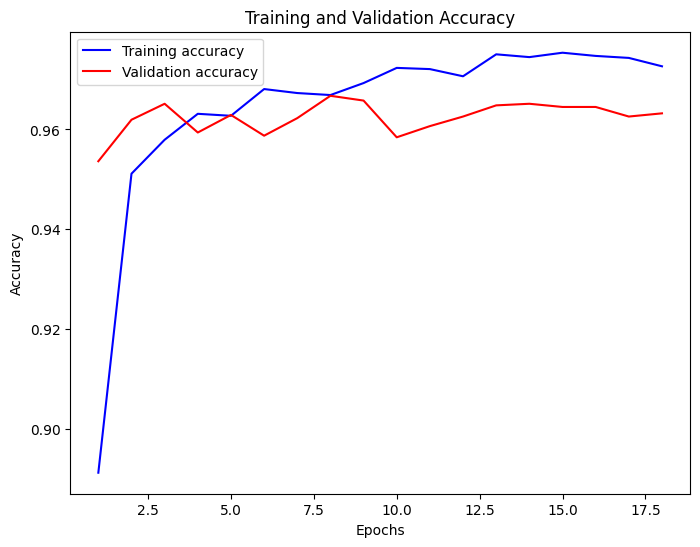

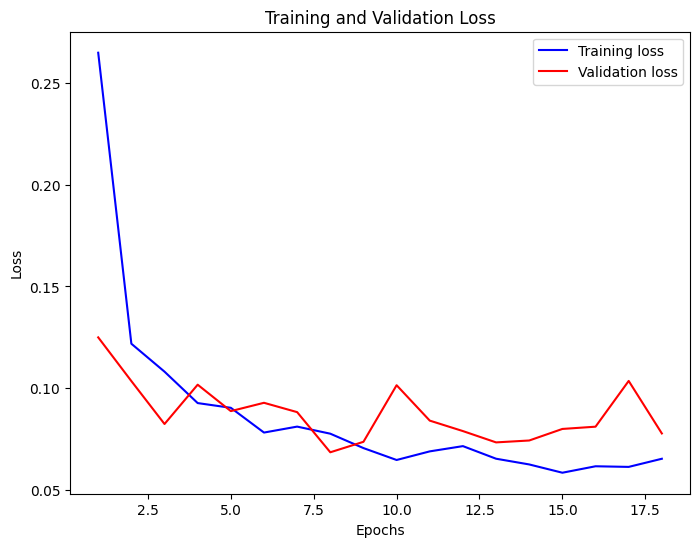

Model Accuracy on Training Data: 97.57%
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12354   177]
 [  203  2897]]
precision =  0.9424202992843201 
 recall =  0.9345161290322581


In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# TODO: summarize history for Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# TODO: Plot the training & validation accuracy over epochs and display the plot
epochs = range(1, len(acc) + 1)
# TODO: Save the plot to a file
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('accuracy_plot.png')
plt.show()

# TODO: summarize history for Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
# TODO: Plot the training & validation loss over epochs and display the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# TODO: Save the plot to a file
plt.savefig('loss_plot.png')
plt.show()

# TODO: Use the evaluate method to calculate the accuracy of the model on the training data
scores = best_model.evaluate(sequence_array, label_array, verbose=0)  # TODO: Replace with the correct code to evaluate the model on the training data

# Print the accuracy of the model on the training data
print(f"Model Accuracy on Training Data: {scores[1]*100:.2f}%")

# make predictions and compute confusion matrix
# TODO: Use the predict method to make predictions on the training data
y_prob = best_model.predict(sequence_array)
# TODO: Convert the predicted probabilities to class labels (e.g., using a threshold of 0.5)
y_pred = (y_prob > 0.5).astype(int) # TODO: Use predict and convert probabilities to class labels
y_true = label_array

# TODO: Create a Pandas DataFrame from the predicted labels and save it to a CSV file
test_set = pd.DataFrame(data={'True Label': y_true.flatten(), 'Predicted Label': y_pred.flatten()})# TODO: Replace with the correct code to create a DataFrame from the predicted labels
test_set.to_csv('predictions.csv', index=False)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
# TODO: Compute the confusion matrix using confusion_matrix from sklearn.metrics
cm = confusion_matrix(y_true, y_pred) # TODO: Replace with the correct code to compute the confusion matrix
print(cm)

# TODO: Calculate the precision using precision_score and recall using recall_score from sklearn.metrics
precision = precision_score(y_true, y_pred)  # TODO: Replace with the correct code to calculate precision
recall = recall_score(y_true, y_pred)  # TODO: Replace with the correct code to calculate recall
print( 'precision = ', precision, '\n', 'recall = ', recall)

## Model Evaluation on Validation set

In [44]:
# TODO: Pick the last sequence for each id in the test data
seq_array_test_last = test_df.groupby('id').apply(lambda x: x.iloc[-1]['sequence']).to_numpy()  # Replace with code to select last sequence for each id

# TODO: Convert to numpy array and ensure float32 data type
seq_array_test_last = np.array(seq_array_test_last, dtype=np.float32)

# TODO: Pick the labels for the selected sequences
y_mask = test_df['sequence'].apply(lambda x: len(x) >= sequence_length)  # TODO: Replace with code to select labels for sequences with length >= sequence_length
label_array_test_last = test_df[y_mask].groupby('id').apply(lambda x: x.iloc[-1]['label']).to_numpy()  # TODO: Replace with code to select labels for the selected sequences

# Reshape and ensure float32 data type
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# TODO: Load the saved model if it exists
if os.path.isfile(model_path):
    estimator = load_model(model_path)  # TODO: Replace with code to load the saved model

# TODO: Evaluate the model on the test data
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last)
print('Accuracy: {}'.format(scores_test[1]))

# TODO: Make predictions and compute confusion matrix
y_pred_test = (estimator.predict(seq_array_test_last) > 0.5).astype(int)  # TODO: Replace with code to make predictions and convert to class labels
y_true_test = label_array_test_last

# TODO: Create pandas dataframe of y_pred_test and save predictions to CSV file
test_set = pd.DataFrame({
    'True_Label': y_true_test.flatten(),
    'Predicted_Label': y_pred_test.flatten()
})
test_set.to_csv('test_predictions.csv', index=False)

# TODO: Compute confusion matrix
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)  # TODO: Replace with code to compute confusion matrix
print(cm)

# TODO: Compute precision, recall, and F1-score
precision_test = precision_score(y_true_test, y_pred_test)  # TODO: Replace with code to compute precision
recall_test = recall_score(y_true_test, y_pred_test)  # TODO: Replace with code to compute recall
f1_test = f1_score(y_true_test, y_pred_test)  # TODO: Replace with code to compute F1-score
print('Precision: ', precision_test, '\n', 'Recall: ', recall_test, '\n', 'F1-score:', f1_test)

# TODO: Plot predicted and actual data for visual verification
plt.figure(figsize=(12, 6))
plt.plot(y_true_test[:100], label='True Labels', marker='o')
plt.plot(y_pred_test[:100], label='Predicted Labels', marker='x')
plt.title('Predicted vs True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.legend()
plt.show()

KeyError: 'sequence'

In [45]:
test_df.head()

,id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.029577,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.061925,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.094272,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.126620,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.158967,138,0,0


In [ ]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM',
                                 'Template Best Model'])
results_df